In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
import holidays
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [3]:
pjme = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv", index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color="green",
          title='PJME MW',
         xlabel="Date",
         ylabel= "Energy usage (MW)")
plt.show()

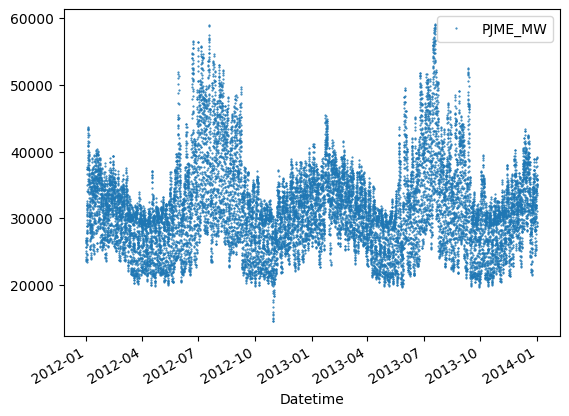

In [5]:
pjme.loc[(pjme.index>="2012-01-01") & (pjme.index<"2014-01-01")].plot(style=".", ms=1)

In [6]:
#finding the likely outage data and removing from the df for more accurate prediction
pjme["PJME_MW"].nsmallest(25)

Datetime
2012-10-30 04:00:00    14544.0
2012-10-30 03:00:00    14586.0
2012-10-30 05:00:00    14821.0
2012-10-30 02:00:00    14955.0
2012-10-30 01:00:00    15390.0
2012-10-30 06:00:00    15526.0
2012-10-30 00:00:00    15919.0
2012-10-30 07:00:00    16688.0
2012-10-29 23:00:00    17422.0
2012-10-30 08:00:00    17734.0
2012-10-31 04:00:00    18330.0
2012-10-31 03:00:00    18350.0
2012-10-31 02:00:00    18618.0
2012-10-30 09:00:00    18675.0
2012-10-31 05:00:00    18880.0
2012-10-29 22:00:00    19085.0
2012-10-31 01:00:00    19155.0
2002-03-31 04:00:00    19247.0
2017-04-16 05:00:00    19255.0
2002-03-31 05:00:00    19258.0
2017-04-16 04:00:00    19278.0
2002-05-12 05:00:00    19360.0
2017-10-01 05:00:00    19367.0
2017-10-01 04:00:00    19393.0
2003-05-26 05:00:00    19414.0
Name: PJME_MW, dtype: float64

<Axes: title={'center': 'PJME MW'}, xlabel='Date', ylabel='Energy usage (MW)'>

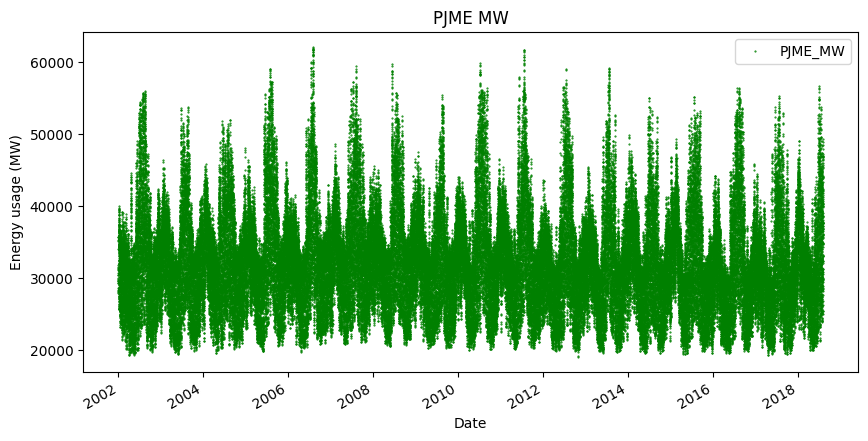

In [7]:
pjme = pjme[pjme['PJME_MW']>19000]
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color="green",
          title='PJME MW',
         xlabel="Date",
         ylabel= "Energy usage (MW)")

[]

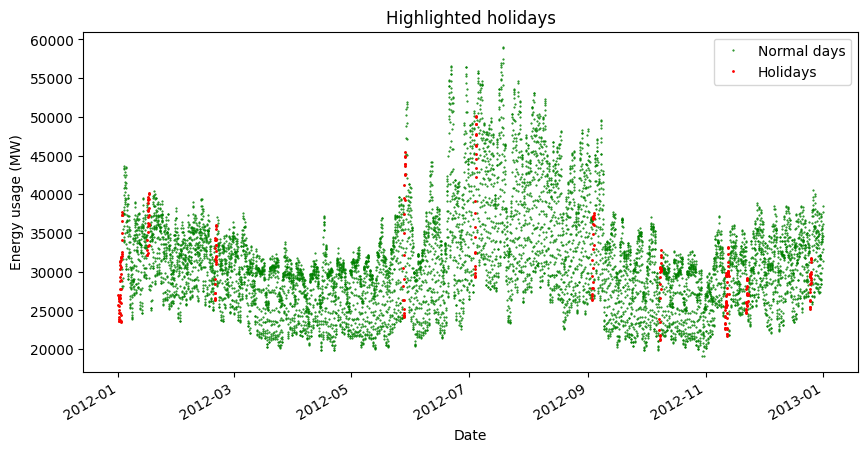

In [8]:
us_holidays=holidays.US()
is_holiday = pjme.index.map(lambda date: date in us_holidays)
filtered_pjme = pjme.loc[is_holiday & (pjme.index >= "2012-01-01") & (pjme.index < "2013-01-01")]
one_year_pjme = pjme.loc[(pjme.index >= "2012-01-01") & (pjme.index < "2013-01-01")]

fig, ax =  plt.subplots(figsize=(10,5))
one_year_pjme.plot(ax=ax, color="green",style=".", ms=1, title="Highlighted holidays")
filtered_pjme.plot(ax=ax, color="red",style=".", ms=2)
ax.legend(["Normal days","Holidays"])
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.plot()

[]

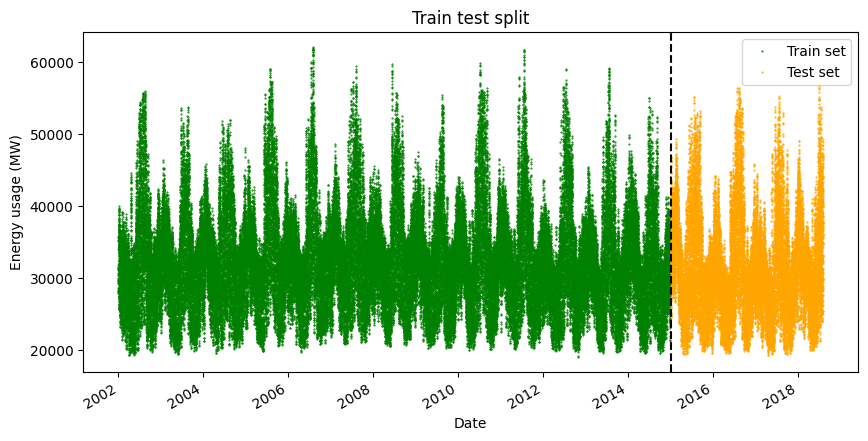

In [9]:
pjme_train = pjme.loc[pjme.index<"2015-01-01"]
pjme_test  = pjme.loc[pjme.index>="2015-01-01"]

fig, ax =  plt.subplots(figsize=(10,5))
pjme_train.plot(ax=ax, color="green", label="Train set", style=".", ms=1, title="Train test split")
pjme_test.plot(ax=ax, color="orange", label="Test set", style=".", ms=1)
ax.axvline("2015-01-01", color="black", ls="--")
ax.legend(["Train set","Test set"])
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.plot()

In [10]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
model = Prophet()
model.fit(pjme_train_prophet)

20:47:32 - cmdstanpy - INFO - Chain [1] start processing
20:49:32 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={"Datetime" : "ds",
                     "PJME_MW" : "y"})
y_preds = model.predict(pjme_test_prophet)

In [ ]:
y_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31211.887623,26012.167410,35127.294004,31211.887623,31211.887623,-865.221867,-865.221867,-865.221867,-2411.116100,...,1287.112752,1287.112752,1287.112752,258.781482,258.781482,258.781482,0.0,0.0,0.0,30346.665757
1,2015-01-01 01:00:00,31211.850810,23932.063983,32659.818857,31211.850810,31211.850810,-2889.079217,-2889.079217,-2889.079217,-4428.844341,...,1279.766353,1279.766353,1279.766353,259.998772,259.998772,259.998772,0.0,0.0,0.0,28322.771593
2,2015-01-01 02:00:00,31211.813997,22624.104489,31676.134463,31211.813997,31211.813997,-4393.252659,-4393.252659,-4393.252659,-5925.622423,...,1271.112044,1271.112044,1271.112044,261.257720,261.257720,261.257720,0.0,0.0,0.0,26818.561338
3,2015-01-01 03:00:00,31211.777184,21432.530522,30332.615595,31211.777184,31211.777184,-5265.015211,-5265.015211,-5265.015211,-6788.829619,...,1261.256054,1261.256054,1261.256054,262.558354,262.558354,262.558354,0.0,0.0,0.0,25946.761973
4,2015-01-01 04:00:00,31211.740371,21510.861335,29971.390847,31211.740371,31211.740371,-5406.678613,-5406.678613,-5406.678613,-6920.899294,...,1250.319979,1250.319979,1250.319979,263.900701,263.900701,263.900701,0.0,0.0,0.0,25805.061757


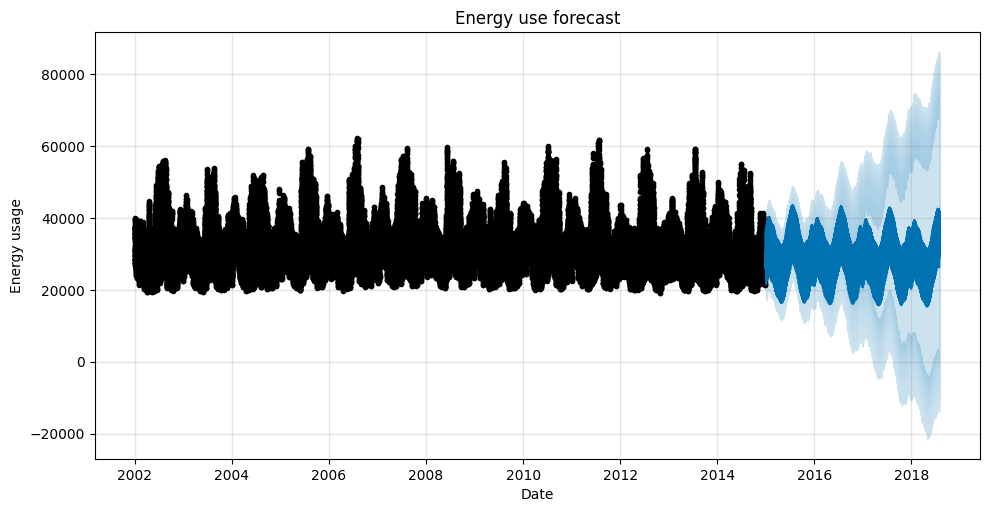

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
fig = model.plot(y_preds, ax=ax)
ax.set_title("Energy use forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage")
plt.show()

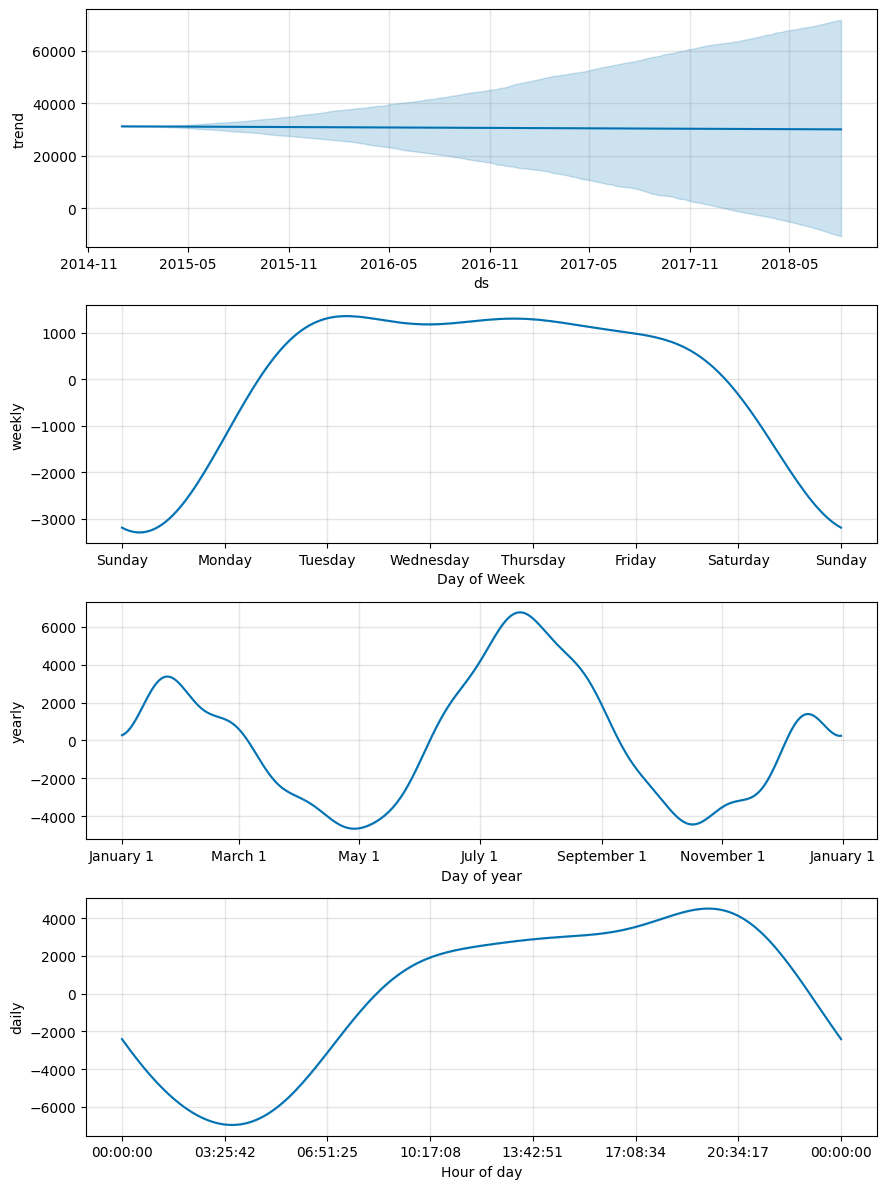

In [ ]:
comp = model.plot_components(y_preds)
plt.show()

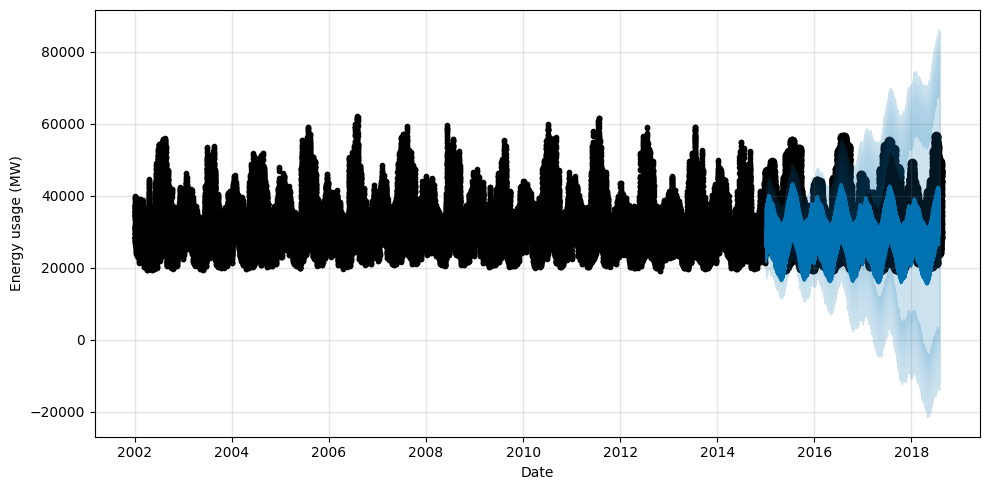

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"], color="black")
model.plot(y_preds, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.show()

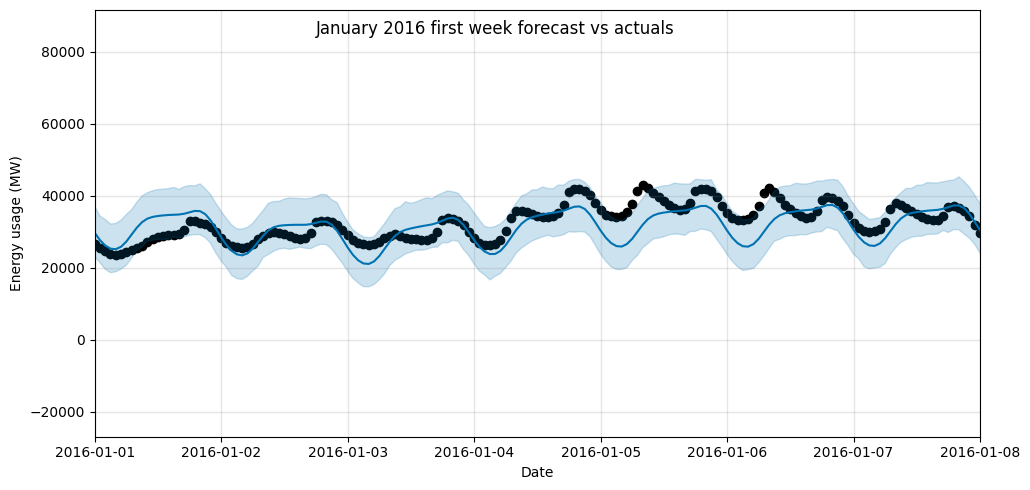

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"], color="black")
model.plot(y_preds, ax=ax)
ax.set_xbound(lower=pd.to_datetime("2016-01-01"),
             upper=pd.to_datetime("2016-01-08"))
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.suptitle("January 2016 first week forecast vs actuals", y=0.95)
plt.show()

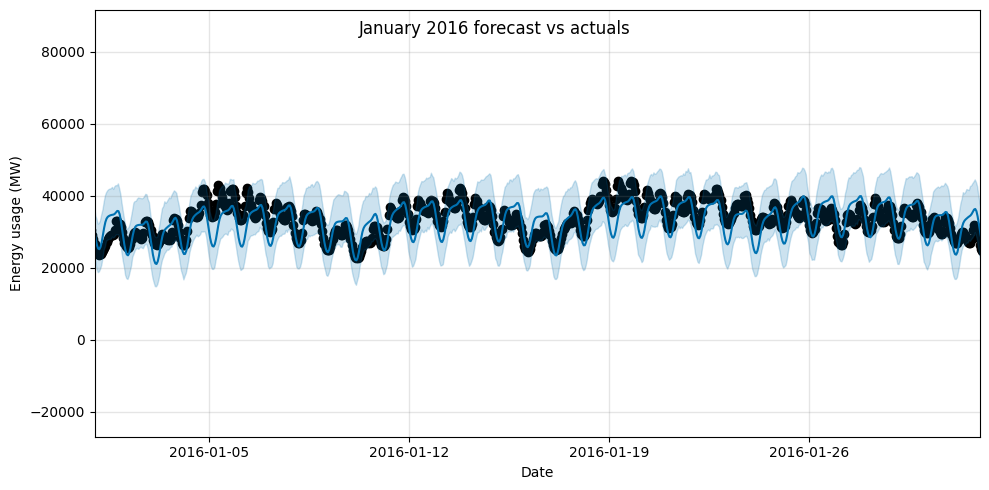

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"], color="black")
model.plot(y_preds, ax=ax)
ax.set_xbound(lower=pd.to_datetime("2016-01-01"),
             upper=pd.to_datetime("2016-02-01"))
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.suptitle("January 2016 forecast vs actuals", y=0.95)
plt.show()

In [ ]:
squared_error = np.sqrt(mean_squared_error(pjme_test["PJME_MW"],y_preds["yhat"]))
squared_error

6616.836357216775

In [ ]:
mean_abs_error = mean_absolute_error(pjme_test["PJME_MW"],y_preds["yhat"])
mean_abs_error

5181.4779964470345

In [ ]:
mean_abs_perc_error = mean_absolute_percentage_error(pjme_test["PJME_MW"],y_preds["yhat"])
mean_abs_perc_error

0.16510252916143364

In [ ]:
import xgboost as xgb

In [ ]:
def create_features(pjme):
    df = pjme.copy()
    df["dayofmonth"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df


In [ ]:
pjme_with_features = create_features(pjme)
pjme_with_features.tail(15)

,PJME_MW,dayofmonth,month,year,quarter,dayofyear,weekofyear,dayofweek,hour
Datetime,,,,,,,,,
2018-01-01 10:00:00,39884.0,1,1,2018,1,1,1,0,10
2018-01-01 11:00:00,39544.0,1,1,2018,1,1,1,0,11
2018-01-01 12:00:00,39270.0,1,1,2018,1,1,1,0,12
2018-01-01 13:00:00,38987.0,1,1,2018,1,1,1,0,13
2018-01-01 14:00:00,38726.0,1,1,2018,1,1,1,0,14
2018-01-01 15:00:00,38737.0,1,1,2018,1,1,1,0,15
2018-01-01 16:00:00,39337.0,1,1,2018,1,1,1,0,16
2018-01-01 17:00:00,41213.0,1,1,2018,1,1,1,0,17
2018-01-01 18:00:00,44147.0,1,1,2018,1,1,1,0,18


<Axes: xlabel='month', ylabel='PJME_MW'>

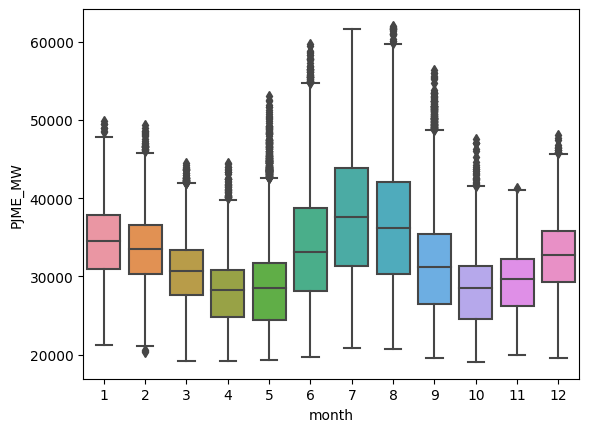

In [ ]:
sns.boxplot(x = "month" , y = "PJME_MW" , data = pjme_with_features)

In [ ]:
pjmef_train = pjme_with_features.loc[pjme.index<"2015-01-01"]
pjmef_test  = pjme_with_features.loc[pjme.index>="2015-01-01"]
X_train , y_train = pjmef_train.drop("PJME_MW" , axis = 1) , pjmef_train["PJME_MW"]
X_test , y_test = pjmef_test.drop("PJME_MW" , axis = 1) , pjmef_test["PJME_MW"]

In [76]:
xgbreg = xgb.XGBRegressor(n_estimators=2000,early_stopping_rounds=50,
                          max_depth=3,
                        learning_rate=0.01)
xgbreg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6422.44744	validation_1-rmse:6496.76076
[100]	validation_0-rmse:4626.17589	validation_1-rmse:4909.48029
[200]	validation_0-rmse:3961.24002	validation_1-rmse:4357.54615
[300]	validation_0-rmse:3592.45922	validation_1-rmse:4061.89343
[400]	validation_0-rmse:3397.40108	validation_1-rmse:3912.52574
[500]	validation_0-rmse:3278.07059	validation_1-rmse:3837.53762
[600]	validation_0-rmse:3200.14302	validation_1-rmse:3788.45238
[700]	validation_0-rmse:3145.51565	validation_1-rmse:3768.23128
[800]	validation_0-rmse:3107.46903	validation_1-rmse:3752.13389
[900]	validation_0-rmse:3075.27527	validation_1-rmse:3742.14209
[1000]	validation_0-rmse:3047.05148	validation_1-rmse:3731.94197
[1100]	validation_0-rmse:3022.62829	validation_1-rmse:3724.27631
[1200]	validation_0-rmse:3001.82164	validation_1-rmse:3721.29172
[1300]	validation_0-rmse:2979.76624	validation_1-rmse:3709.24613
[1357]	validation_0-rmse:2965.39725	validation_1-rmse:3713.46003


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [77]:
pred = xgbreg.predict(X_test)
np.sqrt(mean_squared_error(y_test , pred))


3708.7554969585485

In [ ]:
pred = pd.DataFrame(pred , columns = ["Prediction"] , index = y_test.index)
mean_abs_perc_error = mean_absolute_percentage_error(pjmef_test["PJME_MW"],pred["Prediction"])
mean_abs_perc_error

0.08999566003072819

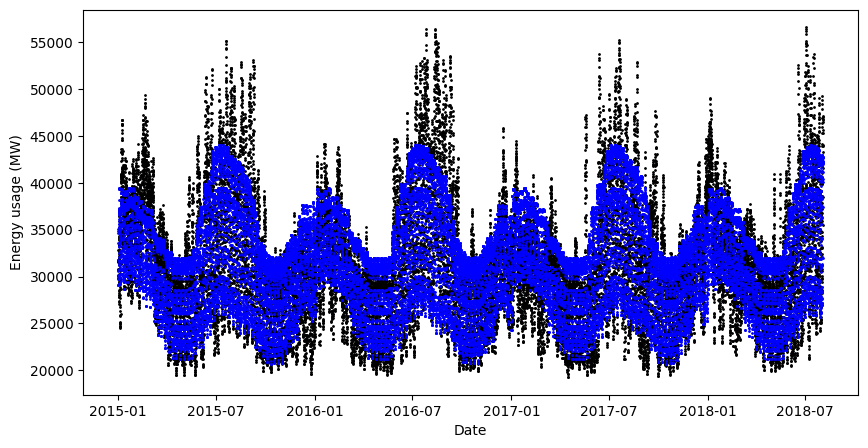

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjmef_test.index, pjmef_test["PJME_MW"], color="black", label='Actual', s=1)
ax.scatter(pred.index, pred["Prediction"], color="blue", label='Prediction', s=1)
ax.set_xlabel("Date")
ax.set_ylabel("Energy usage (MW)")
plt.show()

daily temperature data would be necessary to better predict the outlier peaks